In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

# import scikitplot as skplt

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score

from sklearn.model_selection import GridSearchCV


### Load Testing Data

In [58]:
df = pd.read_csv('Data/train.csv')
df = df.sample(6000)  #60000
X_train = df.drop('labels',axis='columns')
y_train = df['labels'].values.ravel()

In [59]:
print(X_train.shape,y_train.shape)
print(pd.Series(y_train).value_counts(normalize=True))

(6000, 108) (6000,)
1    0.808667
0    0.191333
dtype: float64


### Load Training Data

In [60]:
df = pd.read_csv('Data/test.csv')
df = df.sample(1000)  #10000
X_test = df.drop('labels',axis='columns')
y_test = df['labels'].values.ravel()

In [61]:
print(X_test.shape,y_test.shape)
print(pd.Series(y_test).value_counts(normalize=True))

(1000, 108) (1000,)
1    0.781
0    0.219
dtype: float64


### Fit the models

In [32]:
classifiers = [GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, 
                                          max_features=50, max_depth=15, random_state=0),
               
              LogisticRegression(random_state=666,solver='sag',max_iter=10000,C=5,
                                 class_weight={1:0.3,0:0.7}),
              
              GaussianNB()]

result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc',
                                    'precision','recall',
                                    'precision score'])

for cls in classifiers:
    model = cls.fit(X_train, y_train)
    
    yproba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    precision,recall,_ = precision_recall_curve(y_test,yproba)
    average_precision = average_precision_score(y_test,yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc,
                                        'precision':precision,
                                        'recall':recall,
                                        'precision score':average_precision}, 
                                       ignore_index=True)
    
    print('{} - DONE'.format(cls))

result_table.set_index('classifiers', inplace=True)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=15,
              max_features=50, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False) - DONE
LogisticRegression(C=5, class_weight={1: 0.3, 0: 0.7}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=666,
          solver='sag', tol=0.0001, verbose=0, warm_start=False) - DONE
GaussianNB(priors=None, var_smoothing=1e-09) - DONE


### Recal vs. Precision Curve

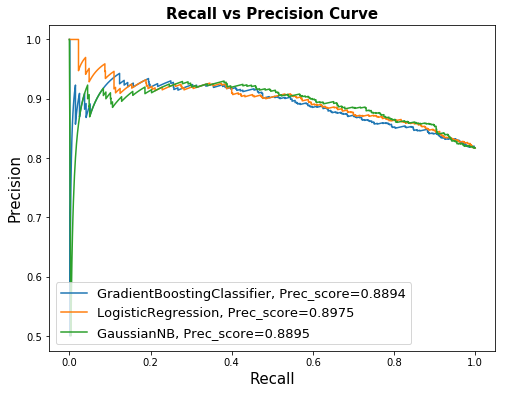

In [36]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['recall'],result_table.loc[i]['precision'],
            label="{}, Prec_score={:.4f}".format(i, result_table.loc[i]['precision score']))
    
plt.xlabel("Recall", fontsize=15)
plt.ylabel("Precision", fontsize=15)

plt.title('Recall vs Precision Curve', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower left')
#plt.savefig('images/recall_precision.png')
plt.show()



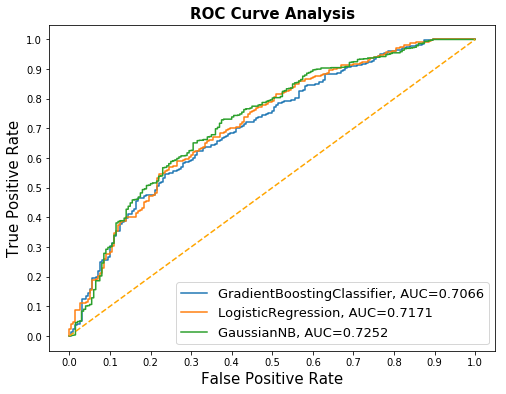

In [38]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.4f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
#plt.savefig('images/ROC.png')
plt.show()

In [41]:
for algo, name in zip(classifiers, result_table.index):
    print("############## {} ##############".format(name))
    prediction = algo.predict(X_test)
    print(classification_report(y_test, prediction))

############## GradientBoostingClassifier ##############
              precision    recall  f1-score   support

           0       0.62      0.16      0.25       200
           1       0.82      0.97      0.89       800

   micro avg       0.81      0.81      0.81      1000
   macro avg       0.72      0.57      0.57      1000
weighted avg       0.78      0.81      0.76      1000

############## LogisticRegression ##############
              precision    recall  f1-score   support

           0       0.43      0.43      0.43       200
           1       0.86      0.86      0.86       800

   micro avg       0.77      0.77      0.77      1000
   macro avg       0.65      0.65      0.65      1000
weighted avg       0.77      0.77      0.77      1000

############## GaussianNB ##############
              precision    recall  f1-score   support

           0       0.48      0.31      0.38       200
           1       0.84      0.92      0.88       800

   micro avg       0.79      0.79  

In [42]:
threshold = 0.9

for algo, name in zip(classifiers, result_table.index):
    print("############## {} ##############".format(name))
    predict_proba = algo.predict_proba(X_test)[:,1] >= threshold
    print(classification_report(y_test, predict_proba))

############## GradientBoostingClassifier ##############
              precision    recall  f1-score   support

           0       0.45      0.28      0.35       200
           1       0.84      0.92      0.87       800

   micro avg       0.79      0.79      0.79      1000
   macro avg       0.64      0.60      0.61      1000
weighted avg       0.76      0.79      0.77      1000

############## LogisticRegression ##############
              precision    recall  f1-score   support

           0       0.21      0.95      0.35       200
           1       0.91      0.11      0.20       800

   micro avg       0.28      0.28      0.28      1000
   macro avg       0.56      0.53      0.27      1000
weighted avg       0.77      0.28      0.23      1000

############## GaussianNB ##############
              precision    recall  f1-score   support

           0       0.48      0.41      0.44       200
           1       0.86      0.89      0.87       800

   micro avg       0.79      0.79  

In [48]:
logreg = LogisticRegression(solver='sag',max_iter=10000)
param = {'C':[10,15,25,20]}
clf = GridSearchCV(logreg,param,scoring='precision',refit=True,cv=10)
clf.fit(X_train,y_train)
print('Best roc_auc: {:.4}, with hyperparameter: {}'.format(clf.best_score_, clf.best_params_))

Best roc_auc: 0.8287, with hyperparameter: {'C': 10}


In [56]:

filename = 'Models/logreg_model.sav'
#the object you want to pickle and the file to which the object has to be saved - filename, write binary. 
outfile = open(filename,'wb')
pickle.dump(logreg, outfile)) ##logisticRegr? ##not saving properly
outfile.close()


# #load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))



## Creating a predictive model - Linear Regression

In [ ]:
# train
linreg = LinearRegression()
linreg.fit(X_train, y_train)

In [ ]:
# predict
y_pred = linreg.predict(X_test)

In [ ]:
coef = pd.DataFrame(linreg.coef_, columns=['Co-efficient'])
attribute = pd.DataFrame(X.columns, columns=['Attribute'])
coef_df = pd.concat([attribute, coef], axis=1, join='inner')

scores, pvalues = chi2(X, y)
pvalues = pd.DataFrame(pvalues, columns=['pvalues'])
coef_df = pd.concat([coef_df, pvalues], axis=1, join='inner')
coef_df


In [ ]:
print('R^2: ', linreg.score(X_train, y_train))
print('R^2: ', linreg.score(X_test, y_test))
print('Mean squared error:  ', mean_squared_error(y_test, y_pred))
print('Root Mean squared error:  ', np.sqrt(mean_squared_error(y_test, y_pred)))

In [ ]:
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.show()

In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import pickle

# # import scikitplot as skplt

# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import GaussianNB

# # from sklearn.metrics import accuracy_score
# from sklearn.metrics import classification_report
# # from sklearn.metrics import f1_score
# from sklearn.metrics import precision_recall_curve
# # from sklearn.metrics import confusion_matrix
# # from sklearn.metrics import plot_roc_curve
# from sklearn.metrics import roc_auc_score
# # from sklearn.metrics import plot_confusion_matrix
# from sklearn.metrics import roc_curve
# # from sklearn.metrics import r2_score
# # from sklearn.metrics import plot_precision_recall_curve
# from sklearn.metrics import average_precision_score

# from sklearn.model_selection import GridSearchCV
# # from sklearn.model_selection import cross_val_score
# # from sklearn.model_selection import learning_curve
# # from sklearn.model_selection import StratifiedKFold
# # from sklearn.model_selection import GridSearchCV
# # from sklearn.model_selection import learning_curve

# # from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# #  # library to plot ML metrics
# # 